-  **Los mapas de activaciones a la salida de las capas.** Son simplemente los resultados que obtenemos a la salida de una determinada capa durante el *forward pass*. Normalmente, cuando visualizamos las activaciones de una red con activaciones de tipo ReLU, necesitamos unas cuantas épocas antes de empezar a ver algo útil. Una cosa para la que son muy útiles es para ver si algún filtro está completamente negro para diferentes entradas, es decir, todos sus elementos son siempre 0. Esto significa que el filtro está muerto, y normalmente pasa cuando entrenamos con learning rates altos.

- **Los filtros aprendidos de los bloques convolucionales**. Normalmente, estos filtros son más interpetables en las primeras capas de la red que en las últimas. Sobre todo, es útil visualizar los filtros de la primera, que está mirando directamente a las imágenes de entrada. Una red bien entrenada tendrá filtros perfectamente definidos, al menos en las primeras capas, y sin practicamente ruido. Si por el contrario tuviésemos filtros con mucho ruido podría deberse a que hace falta entrenar más la red, o a que tenemos overfitting y necesitamos algún método de regularización.


A continuación vamos a llevar a cabo un ejemplo para poner todo lo anterior en práctica. **En primer lugar**, vamos a ver cómo se pueden **visualizar las activaciones de la última capa de nuestra CNN** (llamadas ***saliency map***). Para ello, necesitamos **cambiar la activación de la última capa**, de softmax **a lineal**, para una correcta visualización y antes que nada debemos instalar una librería que nos permita visualizar el interior de las CNNs denominada ***keras-vis***. De nuevo debemos emplear la versión de TensorFlow 1.x debido a la naturaleza de keras-vis.

Antes que nada debemos instalar el paquete **keras-vis**

In [ ]:
!pip install git+https://github.com/raghakot/keras-vis.git -U

In [ ]:
!pip uninstall h5py

In [ ]:
!pip install h5py==2.10.0

**Busquemos la capa** que estamos interesados en visualizar y **cambiamos la función de activación** de la última capa

In [4]:
%tensorflow_version 1.x
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

# Importamos la VGG16 con los pesos de ImageNet y su top_model original
model = VGG16(weights='imagenet', include_top=True)

# Compilamos el modelo
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Buscamos la capa que estamos interesados en visualizar empleando el método find_layer_idx
layer_idx = utils.find_layer_idx(model, 'predictions')

# Cambiamos la activación softmax por la función de activación lineal y aplicamos modificaciones
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

TensorFlow 1.x selected.


Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

553467904/553467096 [==============================] - 24s 0us/step


Acto seguido **cargamos un par de imágenes** sobre las que vamos a ver los mapas de activaciones.

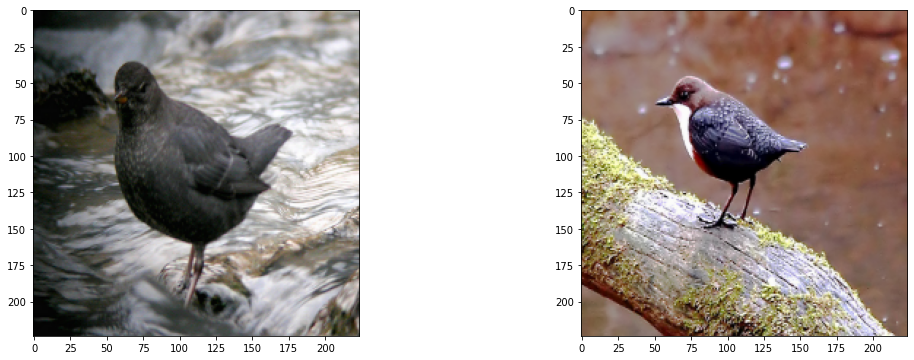

In [5]:
# Imports necesarios
from vis.utils import utils
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6) # tamaño de las imágenes

# Cargamos dos imágenes
img1 = utils.load_img('https://image.ibb.co/ma90yJ/ouzel2.jpg', target_size=(224, 224))
img2 = utils.load_img('https://image.ibb.co/djhyky/ouzel1.jpg', target_size=(224, 224))

# Las mostramos
f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[0].grid(False)
ax[1].imshow(img2)
ax[1].grid(False)

La función que se encarga de mostrarnos el mapa de activación es **```visualize_saliency```** perteneciente al módulo de visualización de la librería ***keras-vis***. A dicha función tenemos que **pasarle el modelo, el ID de la capa, el ID de la clase para la que queremos ver las activaciones, y la imagen para la que queremos ver las activaciones**.

¿Y qué es eso del **ID de la clase** para la que queremos ver las activaciones? Pues ese ID es un **identificador único que tiene cada una de las 1000 clases del dataset ImageNet**. La clase pájaro es la ID=20, por lo cual, si introducimos una imagen de un pájaro, debería activarse bastante dicha clase, e indicarnos en qué se fija para decidir que efectivamente es un pájaro. Si para la misma imagen de entrada (un pájaro) utilizamos ID=64, la red buscaría una *green mamba*, que es una serpiente (como la de la figura de la derecha) por lo que las activaciones deberían ser mucho menores. Vamos a **visualizar** las **activaciones** de la **neurona ID=20** para nuestras imágenes de entrada.

![Paj_serp](https://drive.google.com/uc?id=1RcJ2tFw4_lLtwTHK8xUl0QpsMTK1-MF2)

Para conocer el listado completo de las 1000 clases de ImageNet con sus correspondiente IDs haced click en el siguiente enlace: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

In [ ]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Con esta línea encontramos el índice de la capa predicciones, que es la que queremos ver sus activaciones
layer_idx = utils.find_layer_idx(model, 'predictions')
print('Número de capa: ', layer_idx)

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    
    # 20: 'water ouzel, dipper'
    grads = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=img, backprop_modifier='guided')
    
    # Vamos a ver las activaciones con el colormap=jet, que es adecuado para ver mapas de probabilidades
    ax[i].imshow(grads, cmap='jet')
    ax[i].grid(False)

 A continuación, vamos a probar **otro método de visualización**: el ***cam-saliency***. En este caso, la visualización contiene **más detalles**, ya que **hace uso de la información** no solo de la capa indicada, sino **de la anterior capa Conv o Pool** que encuentre. En nuestro caso sera la capa *max_pool5*.

In [ ]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam, overlay

plt.figure()
f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
  
  # Como no le hemos indicado el parámetro penultimate_layer_idx, escoge la primera que encuentra, que es la max_pool5
  grads = visualize_cam(model, layer_idx, filter_indices=20, seed_input=img, backprop_modifier='guided')        
        
  # Sobreponemos el mapa de activaciones en la imagen original
  jet_heatmap = np.uint8(cm.jet(grads) * 255)[:, :, 0:3]
  ax[i].imshow(overlay(jet_heatmap, img))
  ax[i].grid(False)

¿Qué os ha parecido esto?¿En qué **partes del pájaro** está prestando **atención** la **CNN** para tomar una decisión y **clasificar**?



---



Una vez vistos los mapas de activación, vamos a proceder a ver distintos **filtros de diferentes capas convolucionales**. En primer lugar, vamos a visualizar los filtros de la **primera capa convolucional**:



In [ ]:
from vis.visualization import visualize_activation, get_num_filters

# Buscamos el índice de la capa cuyos filtros queremos visualizar
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(model, layer_name)

# Creamos un array con valores de 0 al núm de filtros a visualizar (en nuestro caso 4 por motivos temporales)
filters = np.arange(4)

# Guardamos cada filtro en vis_images
plt.rcParams['figure.figsize'] = (18, 6) # Tamaño de las imágenes de los filtros
vis_images = []
for idx in filters:
    img = visualize_activation(model, layer_idx, filter_indices=idx)
    
    # Escribimos el índice del filtro
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generamos una imagen donde se visualizen todos
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

Para finalizar, vamos a **visualizar filtros** de diferentes capas pertenecientes a **distintos bloques convolucionales**:

In [ ]:
selected_indices = []
for layer_name in ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(model, layer_name)

    # seleccionamos aleatoriamente 4 filtros de cada capa
    filters = np.random.permutation(get_num_filters(model.layers[layer_idx]))[:4]
    selected_indices.append(filters)

    # generamos el mapa de activaciones
    vis_images = []
    for idx in filters:
        img = visualize_activation(model, layer_idx, filter_indices=idx)

        # escribimos el número de filtro
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # generamos la imagen final a visualizar
    stitched = utils.stitch_images(vis_images, cols=4)
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()